In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import math
from numpy import vstack,array 
from numpy.random import rand
import numpy as np 
from scipy.cluster.vq  import kmeans,vq 
import pandas as pd 
from math import sqrt 
from sklearn.cluster import KMeans 
from matplotlib import pyplot as plt 
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from pycop import archimedean, estimation, mixture, gaussian, empirical
from statsmodels.distributions.empirical_distribution import ECDF
import sympy as sp
from sympy import symbols, diff
from scipy.stats import norm, multivariate_normal
from scipy.special import erfinv
from pycop.bivariate.copula import copula
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

In [2]:
# Preliminaries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# disable warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# all the usual copula cdf and pdf equation
def clayton_pdf(u, v, param):
    term1 = (param + 1) * (u * v) ** (-param - 1)
    term2 = (u ** (-param) + v ** (-param) - 1) ** (-2 - 1 / param)
    return term1 * term2

def clayton_cdf(u, v, param):
    return (u ** (-param) + v ** (-param) - 1) ** (-1 / param)

def gumbel_pdf(u,v,param):
    term1 = (u*v)**(-1)
    tmp = (-sp.log(u))** param + (-sp.log(v))** param
    term2 = tmp ** (-2 + 2.0 / param)
    term3 = (sp.log(u) * sp.log(v)) ** (param - 1)
    term4 = 1 + (param - 1) *  (tmp ** (-1 / param))
    return gumbel_cdf(u,v, param) * term1 * term2 * term3 * term4

def gumbel_cdf(u, v, param):
    return sp.exp(-((-sp.log(u)) ** param + (-sp.log(v)) ** param ) ** (1 / param))

def frank_pdf(u,v, param):
    term1 = param * (1 - sp.exp(-param)) * sp.exp(-param * (u + v))
    term2 = (1 - sp.exp(-param) - (1 - sp.exp(-param * u)) \
                    * (1 - sp.exp(-param * v))) ** 2
    return term1 / term2

def frank_cdf(u,v,param):
    a = (sp.exp(-param * u) - 1) * (sp.exp(-param * v) - 1)
    return (-1 / param) * sp.log(1 + a / (sp.exp(-param) - 1))

def joe_pdf(u,v,param):
    u_ = (1 - u) ** param
    v_ = (1 - v) ** param
    term1 = (u_ + v_ - u_ * v_) ** (-2 + 1 / param)
    term2 = ((1 - u) ** (param - 1)) * ((1 - v) ** (param - 1))
    term3 = param - 1 + u_ + v_ + u_ * v_
    return term1 * term2 * term3

def joe_cdf(u,v,param):
    u_ = (1 - u) ** param
    v_ = (1 - v) ** param
    return 1 - (u_ + v_ - u_ * v_) ** (1 / param)

def galambos_pdf(u,v,param):
    x = -sp.log(u)
    y = -sp.log(v)
    term1 = galambos_cdf(u, v, param) / (v * u)
    term2 = 1 - ((x ** (-param) + y ** (-param)) ** (-1 - 1 / param)) \
                    * (x ** (-param - 1) + y ** (-param - 1))
    term3 = ((x ** (-param) + y ** (-param)) ** (-2 - 1 / param)) \
                    * ((x * y) ** (-param - 1))
    term4 = 1 + param + ((x ** (-param) + y ** (-param)) ** (-1 / param))
    return term1 * term2 + term3 * term4

def galambos_cdf(u,v,param):
    return u * v * sp.exp(((-sp.log(u)) ** (-param[0]) + (-sp.log(v)) ** (-param[0])) ** (-1 / param[0]) )

def fgm_pdf(u,v,param):
    return 1 + param * (1 - 2 * u) * (1 - 2 * v)

def fgm_cdf(u,v,param):
    return u * v * (1 + param * (1 - u) * (1 - v))

def plackett_pdf(u,v,param):
    eta = (param - 1)
    term1 = param * (1 + eta * (u + v - 2 * u * v))
    term2 = (1 + eta * (u + v)) ** 2 
    term3 = 4 * param * eta * u * v
    return term1 / (term2 - term3) ** (3 / 2)

def plackett_cdf(u,v,param):
    eta = param - 1
    term1 = 0.5 * eta ** -1
    term2 = 1 + eta * (u + v)
    term3 = (1 + eta * (u + v)) ** 2
    term4 = 4 * param * eta * u * v
    return term1 * (term2 - (term3 - term4) ** 0.5)

def rclayton_pdf(u,v,param):
    return clayton_pdf(1-u,1-v,param)

def rclayton_cdf(u,v,param):
    return (u + v - 1 + clayton_cdf((1 - u),(1 - v), param) )

def gaussian_pdf(u,v,param):
    rho = param
    a = np.sqrt(2) * erfinv(2 * u - 1)
    b = np.sqrt(2) * erfinv(2 * v - 1)
    det_rho = 1 - rho**2
    return det_rho**-0.5 * sp.exp(-((a**2 + b**2) * rho**2 -2 * a * b * rho) / (2 * det_rho))

def gaussian_cdf(u,v,param):
    y1 = norm.ppf(u, 0, 1)
    y2 = norm.ppf(v, 0, 1)
    rho = param
    return multivariate_normal.cdf((y1,y2), mean=None, cov=[[1, rho], [rho, 1]])

def scad_derivative(beta_hat, lambda_val, a_val):
    if abs(beta_hat) <= lambda_val:
        return lambda_val
    elif lambda_val < abs(beta_hat) <= a_val* lambda_val:
        return ((a_val*lambda_val) - beta_hat)/(a_val-1)
    elif abs(beta_hat) > a_val*lambda_val:
        return 0

In [4]:
def generate_signal(df, upthreshold=0.65, lowerthreshold=0.35, exitthreshold=0.5):
    df['X_position'] = " "
    or_and = 'or'
    if or_and == 'or':
        if df['dfdx'][0] >= upthreshold or df['dfdy'][0]<= lowerthreshold:
            df['X_position'][0] = 1
        elif df['dfdx'][0] <= lowerthreshold or df['dfdy'][0]>= upthreshold:
            df['X_position'][0] = -1
        else:
            df['X_position'][0] = 0

        for i in range(1,len(df)):
            if df['X_position'][i-1] == 0:
                if df['dfdx'][i] >= upthreshold or df['dfdy'][i]<= lowerthreshold:
                    df['X_position'][i] = 1
                elif df['dfdx'][i] <= lowerthreshold or df['dfdy'][i]>= upthreshold:
                    df['X_position'][i] = -1
                else:
                    df['X_position'][i] = 0
            elif df['X_position'][i-1] == 1:
                if df['dfdy'][i] >= exitthreshold or df['dfdx'][i] <= exitthreshold:
                    df['X_position'][i] = 0
                else:
                    df['X_position'][i] = 1
            elif df['X_position'][i-1] == -1:
                if df['dfdy'][i] <= exitthreshold or df['dfdx'][i] >= exitthreshold:
                    df['X_position'][i] = 0
                else:
                    df['X_position'][i] = -1
    else:
        if df['dfdx'][0] >= upthreshold and df['dfdy'][0]<= lowerthreshold:
            df['X_position'][0] = 1
        elif df['dfdx'][0] <= lowerthreshold and df['dfdy'][0]>= upthreshold:
            df['X_position'][0] = -1
        else:
            df['X_position'][0] = 0

        for i in range(1,len(df)):
            if df['X_position'][i-1] == 0:
                if df['dfdx'][i] >= upthreshold and df['dfdy'][i]<= lowerthreshold:
                    df['X_position'][i] = 1
                elif df['dfdx'][i] <= lowerthreshold and df['dfdy'][i]>= upthreshold:
                    df['X_position'][i] = -1
                else:
                    df['X_position'][i] = 0
            elif df['X_position'][i-1] == 1:
                if df['dfdy'][i] >= exitthreshold and df['dfdx'][i] <= exitthreshold:
                    df['X_position'][i] = 0
                else:
                    df['X_position'][i] = 1
            elif df['X_position'][i-1] == -1:
                if df['dfdy'][i] <= exitthreshold and df['dfdx'][i] >= exitthreshold:
                    df['X_position'][i] = 0
                else:
                    df['X_position'][i] = -1
    df['Y_position'] = 0 - df['X_position']
    return df

In [5]:
# # function for backtest returns
# def backtest(d, ret, target, feature):
#     """
#     applying b/s on daily ret, find daily total ret, then cumprod to find cumret
#     input: arr: array containing 3 df, each containing b/s resulting from a k; ret: 1df containing daily ret
#     ouput: res: 1 df containing cumret
#     """
#     # multiply daily ret inplace of b/s, find sum of two ret for daily ret, then cumprod
#     d[f'{target}_ret'] = d[f'{target}'].shift(1) * ret['Y_ret'] 
#     d[f'{feature}_ret'] = d[f'{feature}'].shift(1) * ret['X_ret'] 
#     d['dret'] = d[f'{target}_ret'] + d[f'{feature}_ret']
#     d.dropna(inplace=True)
#     d['cumpl'] = np.cumprod(1 + d['dret'].values)
#     return d


def backtest(df,ret,funds=10000):
    
    initial_funds = funds
    dfx = ret.iloc[:, 0]
    dfy = ret.iloc[:, 1]
    test = df.copy()
    
    test.iloc[0,0]  = 0
    test.iloc[0,1]  = 0
    test.iloc[-1,1]  = 0
    test.iloc[-1,0]  = 0

    test['cumpl'] = " "
    test['cumpl'][0] = 0

    ratio = (dfy[0]/dfx[0])
    
    for i in range(1, len(test)):
        Xshares = funds / dfx.iloc[i]
        Yshares = funds / dfy.iloc[i]
#         if(test.iloc[i,0] - test.iloc[i-1,0] != 0):#If position change != 0, change ratio;otherwise keep it
#             ratio = (dfy[i]/dfx[i])
        test['cumpl'][i] = test['cumpl'][i-1] + (dfx[i] - dfx[i-1])*Xshares*test.iloc[i-1,0] + (dfy[i] - dfy[i-1])*Yshares*test.iloc[i-1,1]
        funds += (dfx[i] - dfx[i-1])*Xshares*test.iloc[i-1,0] + (dfy[i] - dfy[i-1])*Yshares*test.iloc[i-1,1]
    test['dret'] = test['cumpl'] / test['cumpl'].shift(1)
    test['cumpl'] = test['cumpl'] / initial_funds + 1
    return test

In [6]:
def train(df, df_test, pair_name, feature, target, ret_test):
    sl = None
    fl = None
    try:
        cop = mixture(["clayton", "gumbel", "joe"])
        data = df[pair_name].T.values

        param, mle = estimation.fit_cmle_mixt(cop, data)
        w1 = param[0]
        w2 = param[1]
        w3 = param[2]
        theta1 = param[3]
        theta2 = param[4]
        theta3 = param[5]
        sl = tuple(pair_name)

        # Finalize Mixed Copula
        x,y = symbols('x y', real = True) # finding the partial dirivative of the copula function
        f = w1*clayton_cdf(x,y,theta1) + w2*gumbel_cdf(x,y,theta2) + w3*joe_cdf(x,y,theta3)
        dfdx = diff(f, x) # partial derivative of Copula function with respect to x
        dfdy = diff(f, y) # partial derivative of Copula function with respect to x


        df_test['dfdx'] = " "
        df_test['dfdy'] = " "
        for i in range(len(df_test)): # substitue the uniform of two assets to the partial derivative function
            df_test['dfdx'][i] = dfdx.subs([(x,df_test['X_uniform'][i]),(y,df_test['Y_uniform'][i])])
            df_test['dfdy'][i] = dfdy.subs([(x,df_test['X_uniform'][i]),(y,df_test['Y_uniform'][i])])

        df_test = generate_signal(df_test)

        signal = df_test[['X_position', 'Y_position']].rename(columns={'X_position': f'{feature}', 'Y_position': f'{target}'})
        print('signal pass')
        result_test = backtest(signal, ret_test, funds=10000)

        return sl, fl, result_test['cumpl'][-1]
    
    except:
        print('except')
        fl = tuple(pair_name)
        return sl, fl, None


In [7]:
def getdata(root, pair_name):
    target = pair_name[0]
    feature = pair_name[1]
    
    all_data = pd.read_csv(root + 'merged_all_data.csv', index_col='Date', parse_dates=True).iloc[:-414,:]
    dfx = all_data[feature]
    dfy = all_data[target]
    df = all_data[[feature, target]]

    all_data_test = pd.read_csv(root + 'merged_all_data.csv', index_col='Date', parse_dates=True).iloc[-414:,:]
    df_testx = all_data_test[feature]
    df_testy = all_data_test[target]
    df_test = all_data_test[[feature, target]]
    ret_test = df_test.copy(deep=True)
    ret_test['X_ret'] = ret_test.iloc[:,0] / ret_test.iloc[:,0].shift(1) - 1
    ret_test['Y_ret'] = ret_test.iloc[:,1] / ret_test.iloc[:,1].shift(1) - 1
    ret_test['ratio'] = ret_test.iloc[:,1] / ret_test.iloc[:,0]
    
    ecdf_x = ECDF(df_testx) #Get the empirical CDF from the given price list
    ecdf_y = ECDF(df_testy)
    df_test['X_uniform'] = ecdf_x(df_testx) # convert the price distribution to uniform distribution based on ecdf
    df_test['Y_uniform'] = ecdf_y(df_testy)
    df_test['X_uniform'] = df_test['X_uniform'].replace([0.00, 1.00],[0.000001, 0.999999])
    df_test['Y_uniform'] = df_test['Y_uniform'].replace([0.00, 1.00],[0.000001, 0.999999])
    
    return df, df_test, ret_test, feature, target

In [8]:
def run(root, pair_name):
    df, df_test, ret_test, feature, target = getdata(root, pair_name)
    sl, fl, result = train(df, df_test, pair_name, feature, target, ret_test)
    return sl, fl, result

In [9]:
root = 'C:/Users/Allen/Desktop/IAQF/Data/'



In [10]:
all_pairs = [('SPY', 'RUT'),
 ('SPY', 'DJI'),
 ('SPY', 'STI'),
 ('SPY', 'N225'),
 ('SPY', 'IXIC'),
 ('SPY', 'HSI'),
 ('SPY', 'NSEI'),
 ('SPY', 'STOXX50E'),
 ('SPY', 'MID'),
 ('SPY', 'NDX'),
 ('SPY', 'NYA'),
 ('SPY', 'OEX'),
 ('SPY', 'RUA'),
 ('SPY', 'RUI'),
 ('SPY', 'SML'),
 ('SPY', 'SP1500'),
 ('SPY', 'SPX'),
 ('RUT', 'DJI'),
 ('RUT', 'STI'),
 ('RUT', 'N225'),
 ('RUT', 'IXIC'),
 ('RUT', 'HSI'),
 ('RUT', 'NSEI'),
 ('RUT', 'STOXX50E'),
 ('RUT', 'MID'),
 ('RUT', 'NDX'),
 ('RUT', 'NYA'),
 ('RUT', 'OEX'),
 ('RUT', 'RUA'),
 ('RUT', 'RUI'),
 ('RUT', 'SML'),
 ('RUT', 'SP1500'),
 ('RUT', 'SPX'),
 ('DJI', 'STI'),
 ('DJI', 'N225'),
 ('DJI', 'IXIC'),
 ('DJI', 'HSI'),
 ('DJI', 'NSEI'),
 ('DJI', 'STOXX50E'),
 ('DJI', 'MID'),
 ('DJI', 'NDX'),
 ('DJI', 'NYA'),
 ('DJI', 'OEX'),
 ('DJI', 'RUA'),
 ('DJI', 'RUI'),
 ('DJI', 'SML'),
 ('DJI', 'SP1500'),
 ('DJI', 'SPX'),
 ('STI', 'N225'),
 ('STI', 'IXIC'),
 ('STI', 'HSI'),
 ('STI', 'NSEI'),
 ('STI', 'STOXX50E'),
 ('STI', 'MID'),
 ('STI', 'NDX'),
 ('STI', 'NYA'),
 ('STI', 'OEX'),
 ('STI', 'RUA'),
 ('STI', 'RUI'),
 ('STI', 'SML'),
 ('STI', 'SP1500'),
 ('STI', 'SPX'),
 ('N225', 'IXIC'),
 ('N225', 'HSI'),
 ('N225', 'NSEI'),
 ('N225', 'STOXX50E'),
 ('N225', 'MID'),
 ('N225', 'NDX'),
 ('N225', 'NYA'),
 ('N225', 'OEX'),
 ('N225', 'RUA'),
 ('N225', 'RUI'),
 ('N225', 'SML'),
 ('N225', 'SP1500'),
 ('N225', 'SPX'),
 ('IXIC', 'HSI'),
 ('IXIC', 'NSEI'),
 ('IXIC', 'STOXX50E'),
 ('IXIC', 'MID'),
 ('IXIC', 'NDX'),
 ('IXIC', 'NYA'),
 ('IXIC', 'OEX'),
 ('IXIC', 'RUA'),
 ('IXIC', 'RUI'),
 ('IXIC', 'SML'),
 ('IXIC', 'SP1500'),
 ('IXIC', 'SPX'),
 ('HSI', 'NSEI'),
 ('HSI', 'STOXX50E'),
 ('HSI', 'MID'),
 ('HSI', 'NDX'),
 ('HSI', 'NYA'),
 ('HSI', 'OEX'),
 ('HSI', 'RUA'),
 ('HSI', 'RUI'),
 ('HSI', 'SML'),
 ('HSI', 'SP1500'),
 ('HSI', 'SPX'),
 ('NSEI', 'STOXX50E'),
 ('NSEI', 'MID'),
 ('NSEI', 'NDX'),
 ('NSEI', 'NYA'),
 ('NSEI', 'OEX'),
 ('NSEI', 'RUA'),
 ('NSEI', 'RUI'),
 ('NSEI', 'SML'),
 ('NSEI', 'SP1500'),
 ('NSEI', 'SPX'),
 ('STOXX50E', 'MID'),
 ('STOXX50E', 'NDX'),
 ('STOXX50E', 'NYA'),
 ('STOXX50E', 'OEX'),
 ('STOXX50E', 'RUA'),
 ('STOXX50E', 'RUI'),
 ('STOXX50E', 'SML'),
 ('STOXX50E', 'SP1500'),
 ('STOXX50E', 'SPX'),
 ('MID', 'NDX'),
 ('MID', 'NYA'),
 ('MID', 'OEX'),
 ('MID', 'RUA'),
 ('MID', 'RUI'),
 ('MID', 'SML'),
 ('MID', 'SP1500'),
 ('MID', 'SPX'),
 ('NDX', 'NYA'),
 ('NDX', 'OEX'),
 ('NDX', 'RUA'),
 ('NDX', 'RUI'),
 ('NDX', 'SML'),
 ('NDX', 'SP1500'),
 ('NDX', 'SPX'),
 ('NYA', 'OEX'),
 ('NYA', 'RUA'),
 ('NYA', 'RUI'),
 ('NYA', 'SML'),
 ('NYA', 'SP1500'),
 ('NYA', 'SPX'),
 ('OEX', 'RUA'),
 ('OEX', 'RUI'),
 ('OEX', 'SML'),
 ('OEX', 'SP1500'),
 ('OEX', 'SPX'),
 ('RUA', 'RUI'),
 ('RUA', 'SML'),
 ('RUA', 'SP1500'),
 ('RUA', 'SPX'),
 ('RUI', 'SML'),
 ('RUI', 'SP1500'),
 ('RUI', 'SPX'),
 ('SML', 'SP1500'),
 ('SML', 'SPX'),
 ('SP1500', 'SPX')]

In [11]:
all_res = {}
n = -1
for pair in all_pairs:
    n += 1
    print(n)
    pair_name = [pair[0], pair[1]]
    print(pair_name)
    sl, fl, result = run(root, pair_name)
    print(result)
    if fl == None:
        all_res[sl] = result
    else: 
        all_res[fl] = None


0
['SPY', 'RUT']
method: SLSQP - success: True : Optimization terminated successfully
signal pass
1.1740246216687744
1
['SPY', 'DJI']
method: SLSQP - success: False : Singular matrix E in LSQ subproblem
optimization failed
except
None
2
['SPY', 'STI']
method: SLSQP - success: True : Optimization terminated successfully
signal pass
1.1168646342815127
3
['SPY', 'N225']
method: SLSQP - success: True : Optimization terminated successfully
signal pass
2.0622617440107334
4
['SPY', 'IXIC']
method: SLSQP - success: False : Singular matrix E in LSQ subproblem
optimization failed
except
None
5
['SPY', 'HSI']
method: SLSQP - success: True : Optimization terminated successfully
signal pass
1.3147116212027068
6
['SPY', 'NSEI']
method: SLSQP - success: True : Optimization terminated successfully
signal pass
1.9800232609799626
7
['SPY', 'STOXX50E']
method: SLSQP - success: True : Optimization terminated successfully
signal pass
0.8122888243025002
8
['SPY', 'MID']
method: SLSQP - success: True : Optim

method: SLSQP - success: True : Optimization terminated successfully
signal pass
2.1792288551710177
70
['N225', 'RUA']
method: SLSQP - success: False : Singular matrix E in LSQ subproblem
optimization failed
except
None
71
['N225', 'RUI']
method: SLSQP - success: False : Singular matrix E in LSQ subproblem
optimization failed
except
None
72
['N225', 'SML']
method: SLSQP - success: True : Optimization terminated successfully
signal pass
4.020219634852305
73
['N225', 'SP1500']
method: SLSQP - success: True : Optimization terminated successfully
signal pass
2.5037502139539187
74
['N225', 'SPX']
method: SLSQP - success: False : Singular matrix E in LSQ subproblem
optimization failed
except
None
75
['IXIC', 'HSI']
method: SLSQP - success: True : Optimization terminated successfully
signal pass
1.207754049333416
76
['IXIC', 'NSEI']
method: SLSQP - success: True : Optimization terminated successfully
signal pass
1.1606640445121554
77
['IXIC', 'STOXX50E']
method: SLSQP - success: True : Optimi

signal pass
1.170741174634994
138
['OEX', 'RUA']
method: SLSQP - success: False : Singular matrix E in LSQ subproblem
optimization failed
except
None
139
['OEX', 'RUI']
method: SLSQP - success: False : Singular matrix E in LSQ subproblem
optimization failed
except
None
140
['OEX', 'SML']
method: SLSQP - success: True : Optimization terminated successfully
signal pass
1.363972862898196
141
['OEX', 'SP1500']
method: SLSQP - success: False : Singular matrix E in LSQ subproblem
optimization failed
except
None
142
['OEX', 'SPX']
method: SLSQP - success: False : Singular matrix E in LSQ subproblem
optimization failed
except
None
143
['RUA', 'RUI']
method: SLSQP - success: False : Singular matrix E in LSQ subproblem
optimization failed
except
None
144
['RUA', 'SML']
method: SLSQP - success: True : Optimization terminated successfully
signal pass
1.2996762287079024
145
['RUA', 'SP1500']
method: SLSQP - success: False : Singular matrix E in LSQ subproblem
optimization failed
except
None
146
['R

In [12]:
scores = {('SPY', 'RUT'): 6.659267541439502,
 ('SPY', 'DJI'): 2.9888394357676984,
 ('SPY', 'STI'): 53.63458173452184,
 ('SPY', 'N225'): 12.549106401410926,
 ('SPY', 'IXIC'): 3.9471279020986407,
 ('SPY', 'HSI'): 44.7748787025731,
 ('SPY', 'NSEI'): 6.913344047780719,
 ('SPY', 'STOXX50E'): 30.12287785370589,
 ('SPY', 'MID'): 4.166451565424147,
 ('SPY', 'NDX'): 3.134804202259211,
 ('SPY', 'NYA'): 5.3170474258463996,
 ('SPY', 'OEX'): 1.391210463666901,
 ('SPY', 'RUA'): 1.6131268007198398,
 ('SPY', 'RUI'): 1.4171282643298522,
 ('SPY', 'SML'): 4.744921333366047,
 ('SPY', 'SP1500'): 1.2590240733137057,
 ('SPY', 'SPX'): 1.0799129609228688,
 ('RUT', 'DJI'): 5.818024253906165,
 ('RUT', 'STI'): 46.59031742060247,
 ('RUT', 'N225'): 5.955119676315589,
 ('RUT', 'IXIC'): 6.366177595996089,
 ('RUT', 'HSI'): 34.143503865453546,
 ('RUT', 'NSEI'): 8.530570305195413,
 ('RUT', 'STOXX50E'): 21.106185971197103,
 ('RUT', 'MID'): 3.95774331477723,
 ('RUT', 'NDX'): 7.226591479713878,
 ('RUT', 'NYA'): 3.990593976764495,
 ('RUT', 'OEX'): 5.669716365846773,
 ('RUT', 'RUA'): 5.052465935590404,
 ('RUT', 'RUI'): 5.240713063588163,
 ('RUT', 'SML'): 3.228467065171797,
 ('RUT', 'SP1500'): 5.352879596002264,
 ('RUT', 'SPX'): 5.554595074129058,
 ('DJI', 'STI'): 51.462658028463125,
 ('DJI', 'N225'): 10.896630584890394,
 ('DJI', 'IXIC'): 5.418981396670143,
 ('DJI', 'HSI'): 41.83884015262839,
 ('DJI', 'NSEI'): 7.105430728471693,
 ('DJI', 'STOXX50E'): 26.532451771873315,
 ('DJI', 'MID'): 3.55586267516376,
 ('DJI', 'NDX'): 5.168710257432612,
 ('DJI', 'NYA'): 4.4725432779770555,
 ('DJI', 'OEX'): 3.8283076252073935,
 ('DJI', 'RUA'): 3.321849344121203,
 ('DJI', 'RUI'): 3.320165233201599,
 ('DJI', 'SML'): 3.9582220103482095,
 ('DJI', 'SP1500'): 3.035461934281262,
 ('DJI', 'SPX'): 3.1349883534786653,
 ('STI', 'N225'): 46.978235545867655,
 ('STI', 'IXIC'): 53.52460450295322,
 ('STI', 'HSI'): 31.31829124726099,
 ('STI', 'NSEI'): 47.41236831273526,
 ('STI', 'STOXX50E'): 27.87032334395091,
 ('STI', 'MID'): 48.354470566002355,
 ('STI', 'NDX'): 54.75403632682885,
 ('STI', 'NYA'): 45.71600254941165,
 ('STI', 'OEX'): 52.600419935763654,
 ('STI', 'RUA'): 51.57754985135031,
 ('STI', 'RUI'): 51.915723553198895,
 ('STI', 'SML'): 48.01555600537974,
 ('STI', 'SP1500'): 51.93281483630722,
 ('STI', 'SPX'): 52.27323639076376,
 ('N225', 'IXIC'): 8.426182867242359,
 ('N225', 'HSI'): 25.544671305112544,
 ('N225', 'NSEI'): 16.341728426153328,
 ('N225', 'STOXX50E'): 21.33765626450305,
 ('N225', 'MID'): 10.186123522555635,
 ('N225', 'NDX'): 9.771206831054934,
 ('N225', 'NYA'): 8.143785637557261,
 ('N225', 'OEX'): 11.061900395463436,
 ('N225', 'RUA'): 10.476692531673862,
 ('N225', 'RUI'): 10.693793486578212,
 ('N225', 'SML'): 8.619654912393214,
 ('N225', 'SP1500'): 11.244744302905476,
 ('N225', 'SPX'): 11.251474614747263,
 ('IXIC', 'HSI'): 38.58844540305643,
 ('IXIC', 'NSEI'): 9.652480582503234,
 ('IXIC', 'STOXX50E'): 28.260601971672944,
 ('IXIC', 'MID'): 6.103014065465569,
 ('IXIC', 'NDX'): 1.3329857179503062,
 ('IXIC', 'NYA'): 6.729691185857909,
 ('IXIC', 'OEX'): 2.7213955491233492,
 ('IXIC', 'RUA'): 2.8833598476934323,
 ('IXIC', 'RUI'): 2.9459112206626314,
 ('IXIC', 'SML'): 5.951914751040796,
 ('IXIC', 'SP1500'): 3.415145893180335,
 ('IXIC', 'SPX'): 3.35677696716853,
 ('HSI', 'NSEI'): 47.49807926866683,
 ('HSI', 'STOXX50E'): 18.70180155850386,
 ('HSI', 'MID'): 40.7734986403277,
 ('HSI', 'NDX'): 40.79023282413575,
 ('HSI', 'NYA'): 37.23225954936724,
 ('HSI', 'OEX'): 42.43754958559383,
 ('HSI', 'RUA'): 41.624452252757514,
 ('HSI', 'RUI'): 42.05930461958209,
 ('HSI', 'SML'): 39.02073371012399,
 ('HSI', 'SP1500'): 42.8312202395118,
 ('HSI', 'SPX'): 42.85580110296077,
 ('NSEI', 'STOXX50E'): 26.245246246889362,
 ('NSEI', 'MID'): 5.00237874651329,
 ('NSEI', 'NDX'): 9.782242489571312,
 ('NSEI', 'NYA'): 5.0239733351180975,
 ('NSEI', 'OEX'): 7.152620523429104,
 ('NSEI', 'RUA'): 6.563862177294216,
 ('NSEI', 'RUI'): 6.593226595543315,
 ('NSEI', 'SML'): 6.2720024858024335,
 ('NSEI', 'SP1500'): 6.344825103891814,
 ('NSEI', 'SPX'): 6.492007951218798,
 ('STOXX50E', 'MID'): 23.854271576911323,
 ('STOXX50E', 'NDX'): 30.000802810286793,
 ('STOXX50E', 'NYA'): 21.244334255067574,
 ('STOXX50E', 'OEX'): 28.417525163137473,
 ('STOXX50E', 'RUA'): 27.34700056360304,
 ('STOXX50E', 'RUI'): 27.936543393678935,
 ('STOXX50E', 'SML'): 22.548940498354636,
 ('STOXX50E', 'SP1500'): 28.150573322733113,
 ('STOXX50E', 'SPX'): 28.33508645057733,
 ('MID', 'NDX'): 6.388110397528889,
 ('MID', 'NYA'): 2.586846344786588,
 ('MID', 'OEX'): 4.112808669806701,
 ('MID', 'RUA'): 3.1979881477578718,
 ('MID', 'RUI'): 3.409876097923576,
 ('MID', 'SML'): 2.755216284224624,
 ('MID', 'SP1500'): 3.186261749913962,
 ('MID', 'SPX'): 3.4997371912659943,
 ('NDX', 'NYA'): 7.348180320315671,
 ('NDX', 'OEX'): 2.2213173792947303,
 ('NDX', 'RUA'): 2.6993525222531374,
 ('NDX', 'RUI'): 2.698103237778591,
 ('NDX', 'SML'): 6.581200969843042,
 ('NDX', 'SP1500'): 3.0872255517028218,
 ('NDX', 'SPX'): 2.928357943576336,
 ('NYA', 'OEX'): 5.0867198296977465,
 ('NYA', 'RUA'): 4.104299562509795,
 ('NYA', 'RUI'): 4.314335451900641,
 ('NYA', 'SML'): 3.445445495073454,
 ('NYA', 'SP1500'): 4.209469483305215,
 ('NYA', 'SPX'): 4.478479359453527,
 ('OEX', 'RUA'): 1.3094454294093416,
 ('OEX', 'RUI'): 1.1242071513319267,
 ('OEX', 'SML'): 4.4636035228278566,
 ('OEX', 'SP1500'): 1.278021564776131,
 ('OEX', 'SPX'): 1.0846019684078372,
 ('RUA', 'RUI'): 0.6181400883186104,
 ('RUA', 'SML'): 3.7410336667593955,
 ('RUA', 'SP1500'): 1.0314875689132725,
 ('RUA', 'SPX'): 1.1210321767733458,
 ('RUI', 'SML'): 3.833882355883689,
 ('RUI', 'SP1500'): 0.9042410294730582,
 ('RUI', 'SPX'): 0.871937910571373,
 ('SML', 'SP1500'): 3.7914439493999827,
 ('SML', 'SPX'): 3.982819968043292,
 ('SP1500', 'SPX'): 0.5756655588284021}

In [13]:
whole = {}
for k in scores:
    whole[k] = [scores[k], all_res[k]]
whole

{('SPY', 'RUT'): [6.659267541439502, 1.1740246216687744],
 ('SPY', 'DJI'): [2.9888394357676984, None],
 ('SPY', 'STI'): [53.63458173452184, 1.1168646342815127],
 ('SPY', 'N225'): [12.549106401410926, 2.0622617440107334],
 ('SPY', 'IXIC'): [3.9471279020986407, None],
 ('SPY', 'HSI'): [44.7748787025731, 1.3147116212027068],
 ('SPY', 'NSEI'): [6.913344047780719, 1.9800232609799626],
 ('SPY', 'STOXX50E'): [30.12287785370589, 0.8122888243025002],
 ('SPY', 'MID'): [4.166451565424147, 1.2383566116485305],
 ('SPY', 'NDX'): [3.134804202259211, None],
 ('SPY', 'NYA'): [5.3170474258463996, 1.1680724513205951],
 ('SPY', 'OEX'): [1.391210463666901, None],
 ('SPY', 'RUA'): [1.6131268007198398, None],
 ('SPY', 'RUI'): [1.4171282643298522, None],
 ('SPY', 'SML'): [4.744921333366047, 1.3095540335086437],
 ('SPY', 'SP1500'): [1.2590240733137057, None],
 ('SPY', 'SPX'): [1.0799129609228688, None],
 ('RUT', 'DJI'): [5.818024253906165, 1.2094718189524378],
 ('RUT', 'STI'): [46.59031742060247, 0.79871778173

In [14]:
allscores = pd.DataFrame(np.vstack(list(whole.values()))).rename(columns=lambda x: f'v{x+1}')
allscores.insert(0,'Key',list(whole.keys()))

In [15]:
allscores = allscores.fillna(value=np.nan)

In [16]:
allscores

,Key,v1,v2
0,"(SPY, RUT)",6.659268,1.174025
1,"(SPY, DJI)",2.988839,NaN
2,"(SPY, STI)",53.634582,1.116865
3,"(SPY, N225)",12.549106,2.062262
4,"(SPY, IXIC)",3.947128,NaN
...,...,...,...
148,"(RUI, SP1500)",0.904241,NaN
149,"(RUI, SPX)",0.871938,NaN
150,"(SML, SP1500)",3.791444,1.212773
151,"(SML, SPX)",3.982820,1.196546


In [17]:
failed = allscores[allscores.isna().any(axis=1)]

In [18]:
failed

,Key,v1,v2
1,"(SPY, DJI)",2.988839,NaN
4,"(SPY, IXIC)",3.947128,NaN
9,"(SPY, NDX)",3.134804,NaN
11,"(SPY, OEX)",1.391210,NaN
12,"(SPY, RUA)",1.613127,NaN
13,"(SPY, RUI)",1.417128,NaN
15,"(SPY, SP1500)",1.259024,NaN
16,"(SPY, SPX)",1.079913,NaN
30,"(RUT, SML)",3.228467,NaN
35,"(DJI, IXIC)",5.418981,NaN


In [19]:
failed.describe()

,v1,v2
count,36.000000,0.0
mean,3.063584,NaN
std,2.701025,NaN
min,0.575666,NaN
25%,1.225320,NaN
50%,2.855117,NaN
75%,3.436294,NaN
max,11.251475,NaN


(array([ 0.,  4., 11.,  1.,  1.,  2.,  9.,  2.,  1.,  0.,  2.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5]),
 <BarContainer object of 11 artists>)

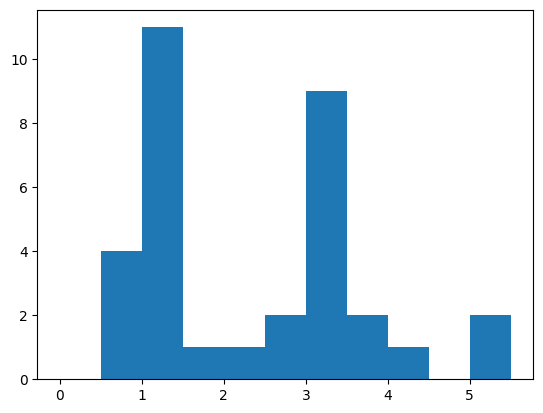

In [20]:
plt.hist(failed.v1, bins=list(np.arange(0, 6, 0.5)))

In [21]:
allscores.iloc[allscores['v2'].idxmax(),:]

Key    (RUT, N225)
v1         5.95512
v2        4.266627
Name: 19, dtype: object

In [22]:
returned = allscores.dropna()
returned = returned.sort_values(by=['v2'], ascending=False)


In [23]:
returned.head(20)

,Key,v1,v2
19,"(RUT, N225)",5.955120,4.266627
72,"(N225, SML)",8.619655,4.020220
66,"(N225, MID)",10.186124,3.200410
95,"(HSI, SML)",39.020734,2.602347
34,"(DJI, N225)",10.896631,2.538992
73,"(N225, SP1500)",11.244744,2.503750
68,"(N225, NYA)",8.143786,2.444886
89,"(HSI, MID)",40.773499,2.345344
37,"(DJI, NSEI)",7.105431,2.327012
21,"(RUT, HSI)",34.143504,2.285177


In [24]:
returned.tail(20)

,Key,v1,v2
77,"(IXIC, STOXX50E)",28.260602,1.075458
24,"(RUT, MID)",3.957743,1.068673
118,"(MID, NYA)",2.586846,1.067140
128,"(NDX, RUI)",2.698103,1.044374
98,"(NSEI, STOXX50E)",26.245246,1.039046
51,"(STI, NSEI)",47.412368,1.025005
54,"(STI, NDX)",54.754036,0.993831
26,"(RUT, NYA)",3.990594,0.988188
113,"(STOXX50E, RUI)",27.936543,0.984769
110,"(STOXX50E, NYA)",21.244334,0.978742


Text(0.5, 0, 'Terminal Value Mutiplier')

Text(0, 0.5, 'Observations')

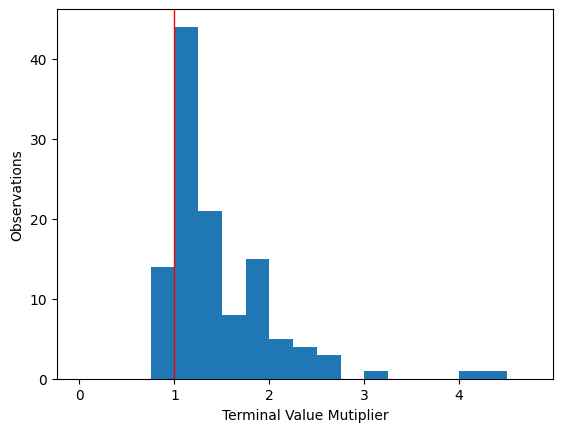

In [25]:
_ = plt.hist(returned.v2, bins=list(np.arange(0, 5, 0.25)))
_ = plt.axvline(x=1, color='r', linewidth=1)
plt.xlabel("Terminal Value Mutiplier")
plt.ylabel("Observations")

In [26]:
mean_ret = returned.v2.mean()
mean_ret

1.469838027474353

In [27]:
returned['v2'].describe()

count    117.000000
mean       1.469838
std        0.572281
min        0.798718
25%        1.141383
50%        1.262851
75%        1.750568
max        4.266627
Name: v2, dtype: float64

In [28]:
returned.iloc[:20,2].mean()

2.44350227597008

In [29]:
returned

,Key,v1,v2
19,"(RUT, N225)",5.955120,4.266627
72,"(N225, SML)",8.619655,4.020220
66,"(N225, MID)",10.186124,3.200410
95,"(HSI, SML)",39.020734,2.602347
34,"(DJI, N225)",10.896631,2.538992
...,...,...,...
130,"(NDX, SP1500)",3.087226,0.897020
131,"(NDX, SPX)",2.928358,0.884956
52,"(STI, STOXX50E)",27.870323,0.840687
7,"(SPY, STOXX50E)",30.122878,0.812289


In [30]:
nonusl = ['N225', 'STI', 'HSI', 'NSEI', 'STOXX50E']
returned['nonUS'] = False
for i in range(len(returned)):
    for x in nonusl:
        if x in returned.iloc[i,0]:
            returned.iloc[i, 3] = True
returned.head(40)

,Key,v1,v2,nonUS
19,"(RUT, N225)",5.955120,4.266627,True
72,"(N225, SML)",8.619655,4.020220,True
66,"(N225, MID)",10.186124,3.200410,True
95,"(HSI, SML)",39.020734,2.602347,True
34,"(DJI, N225)",10.896631,2.538992,True
73,"(N225, SP1500)",11.244744,2.503750,True
68,"(N225, NYA)",8.143786,2.444886,True
89,"(HSI, MID)",40.773499,2.345344,True
37,"(DJI, NSEI)",7.105431,2.327012,True
21,"(RUT, HSI)",34.143504,2.285177,True


In [31]:
returned_US = returned[returned['nonUS'] == False]
returned_NUS = returned[returned['nonUS'] == True]
mean_ret_US = returned_US.v2.mean()
mean_ret_NUS = returned_NUS.v2.mean()
mean_ret_US

1.2135261569062332

In [37]:
returned_US.describe()

,v1,v2
count,45.000000,45.000000
mean,4.534132,1.213526
std,1.351617,0.200753
min,2.586846,0.884956
25%,3.445445,1.109643
50%,4.209469,1.198584
75%,5.554595,1.275646
max,7.348180,1.894453


Text(0.5, 0, 'FDTW Distance')

Text(0, 0.5, 'Terminal Value Mutiplier')

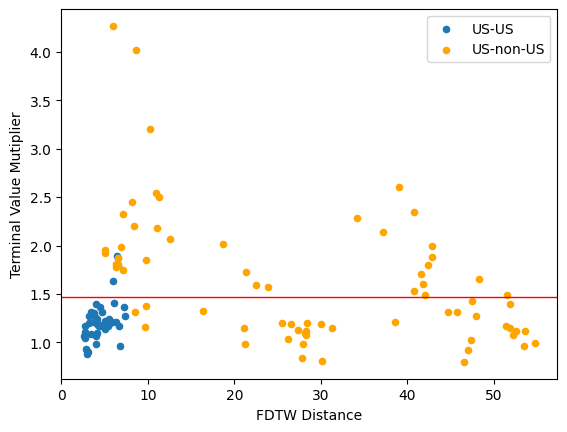

In [32]:
# ax1 = returned_US.plot.scatter(x='v1', y='v2',c=returned.nonUS)

ax1 = returned_US.plot(kind='scatter', x='v1', y='v2', label='US-US') 
_ = returned_NUS.plot(kind='scatter', x='v1', y='v2', color='orange', ax=ax1, label='US-non-US')  
ax1.axhline(y=mean_ret, color='r', linewidth=1,  label= 'horizontal-line')

plt.xlabel("FDTW Distance")
plt.ylabel("Terminal Value Mutiplier")

# _ = df.plot(kind='scatter', x='c', y='d', color='g', ax=ax1)    
# _ = df.plot(kind='scatter', x='e', y='f', color='b', ax=ax1)


# ax1.scatter(x[:4], y[:4], s=10, c='b', marker="s", label='first')
# ax1.scatter(x[40:],y[40:], s=10, c='r', marker="o", label='second')


Text(0.5, 0, 'FDTW Distance')

Text(0, 0.5, 'Terminal Value Mutiplier')

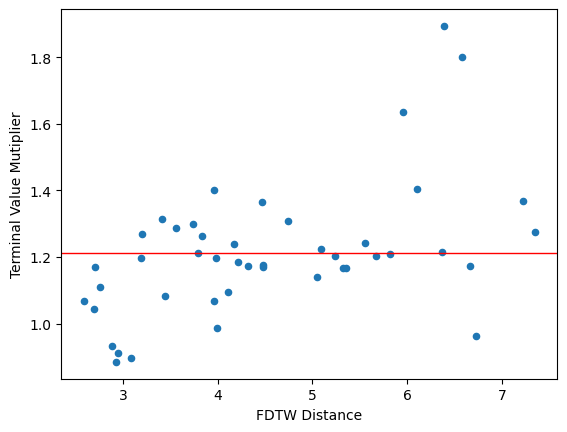

In [33]:
ax2 = returned_US.plot.scatter(x='v1', y='v2')
ax2.axhline(y=mean_ret_US, color='r', linewidth=1)
plt.xlabel("FDTW Distance")
plt.ylabel("Terminal Value Mutiplier")

Text(0.5, 0, 'Terminal Value Mutiplier')

Text(0, 0.5, 'Observations')

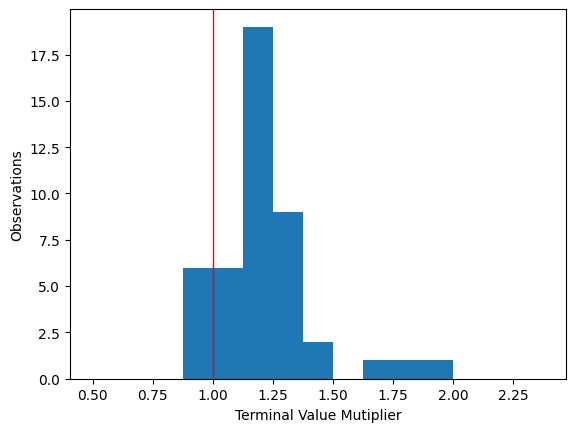

In [34]:
_ = plt.hist(returned_US.v2, bins=list(np.arange(0.5, 2.5, 0.125)))
_ = plt.axvline(x=1, color='r', linewidth=1)
plt.xlabel("Terminal Value Mutiplier")
plt.ylabel("Observations")